In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import os
import scipy.io
import seaborn as sb
import anndata

import matplotlib.pyplot as plt
%matplotlib inline

save_path = "/home/ubuntu/mouse_lymph_node/nova/"

In [2]:
nova_data = sc.read_h5ad("nova_processed_data.h5ad")

## visualize the data

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


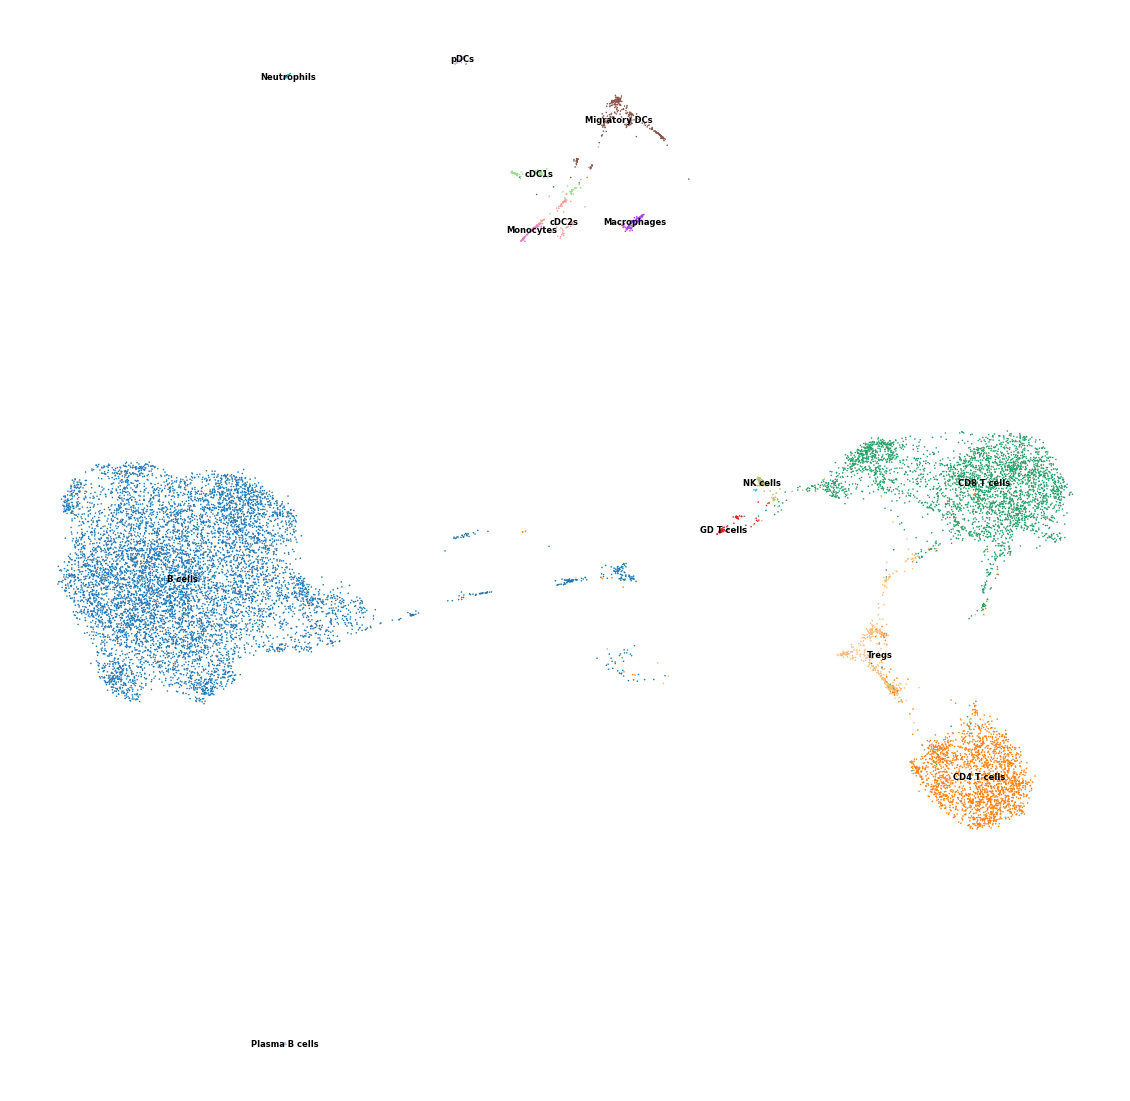

In [3]:
fig, ax = plt.subplots(figsize=(20, 20))
sc.pl.umap(
    nova_data, 
    color="cell_types",
    frameon=False,
    title="",
    legend_loc="on data",
    legend_fontsize="small",
    ax=ax, size=10
)

### Perform more in depth clustering (this must be fine tuned for every run)

In [4]:
sc.tl.louvain(nova_data, restrict_to = ("cell_types", ["B cells"]), key_added="louvain_sub", resolution=0.7, random_state=0)

In [5]:
sc.tl.louvain(nova_data, restrict_to = ("louvain_sub", ["Monocytes"]), key_added="louvain_sub_1", resolution=0.7, random_state=0)

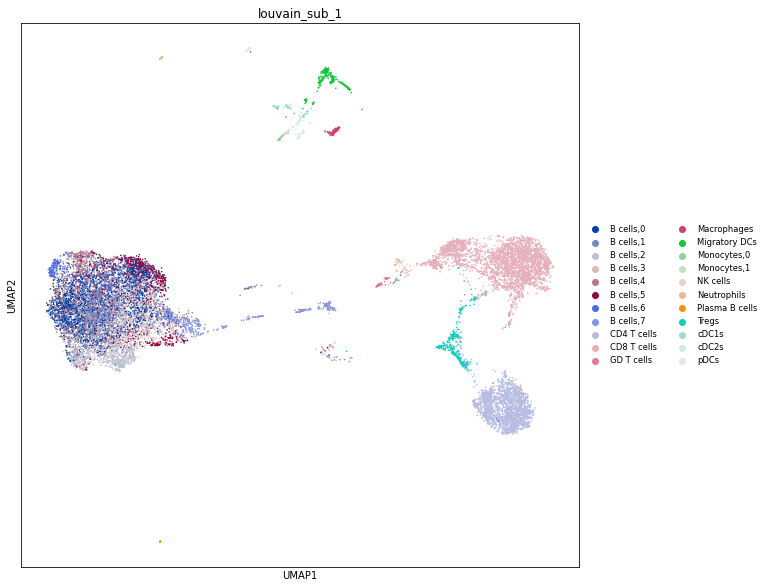

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
sc.pl.umap(
    nova_data, 
    color="louvain_sub_1",
    legend_fontsize="small",
    ax=ax, size=10
)

In [7]:
def study_labels_heterogeneity(key_1, key_2):
    plt.figure(figsize=(10, 10))
    profile = pd.DataFrame(data=nova_data.obs[[key_1, key_2]])
    x_list = np.unique(nova_data.obs[key_1])
    y_list = np.unique(nova_data.obs[key_2])
    x_n = len(x_list)
    y_n = len(y_list)

    proportion = np.zeros(shape=(x_n, y_n))
    for i, x in enumerate(x_list):
        for j, y in enumerate(y_list):
            proportion[i, j] = np.sum(profile[profile[key_1] == x][key_2] == y)
    proportion /= np.sum(proportion, axis=1)[:, np.newaxis] 

    plt.imshow(proportion.T)
    plt.colorbar()
    plt.xticks(range(x_n), x_list, rotation=35)
    plt.yticks(range(y_n), y_list, rotation=35)
    plt.xlabel(key_1)
    plt.ylabel(key_2)
    plt.show()
    
    for i, x in enumerate(x_list):
        line_string = F'Cluster {x}: '
        pile = []
        # empile
        for j, y in enumerate(y_list):
            if proportion[i, j] > 0.05:
                pile.append([y, proportion[i, j]])
        # depile
        for y, p in sorted(pile, key=lambda x:x[1])[::-1]:
            line_string += F'{y} present at ratio {p:.2f}, '
        print(line_string)

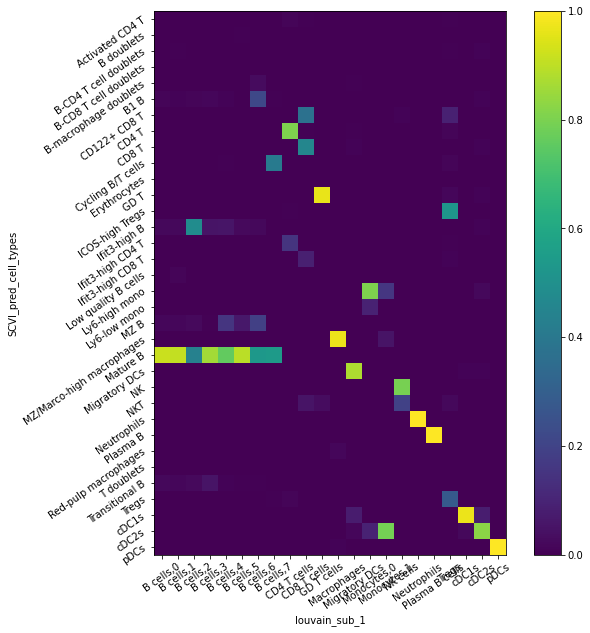

Cluster B cells,0: Mature B present at ratio 0.92, 
Cluster B cells,1: Mature B present at ratio 0.91, 
Cluster B cells,2: Ifit3-high B present at ratio 0.49, Mature B present at ratio 0.44, 
Cluster B cells,3: Mature B present at ratio 0.86, Transitional B present at ratio 0.05, Ifit3-high B present at ratio 0.05, 
Cluster B cells,4: Mature B present at ratio 0.76, MZ B present at ratio 0.15, Ifit3-high B present at ratio 0.06, 
Cluster B cells,5: Mature B present at ratio 0.89, MZ B present at ratio 0.07, 
Cluster B cells,6: Mature B present at ratio 0.53, B1 B present at ratio 0.22, MZ B present at ratio 0.19, 
Cluster B cells,7: Mature B present at ratio 0.54, Cycling B/T cells present at ratio 0.41, 
Cluster CD4 T cells: CD4 T present at ratio 0.80, Ifit3-high CD4 T present at ratio 0.15, 
Cluster CD8 T cells: CD8 T present at ratio 0.46, CD122+ CD8 T present at ratio 0.37, Ifit3-high CD8 T present at ratio 0.09, NKT present at ratio 0.05, 
Cluster GD T cells: GD T present at rati

In [8]:
study_labels_heterogeneity("louvain_sub_1", "SCVI_pred_cell_types")

In [12]:
annotations = {"B cells,0": "Mature B cells", 
               "B cells,1": "Mature B cells", 
               "B cells,2": "Ifit3-high B cells",
               "B cells,3": "Mature B cells", 
               "B cells,4": "Mature B cells", 
               "B cells,5": "Mature B cells", 
               "B cells,6": "Mature B cells",
               "B cells,7": "Cycling B/T cells",
               "Monocytes,0": "Ly6-high monocytes",
               "Monocytes,1": "Cxcl9-high monocytes"
               }

In [13]:
cell_types = []
for c in nova_data.obs["louvain_sub_1"]:
    if c in annotations:
        cell_types.append(annotations[c])
    else:
        cell_types.append(c)
nova_data.obs["cell_types"] = cell_types

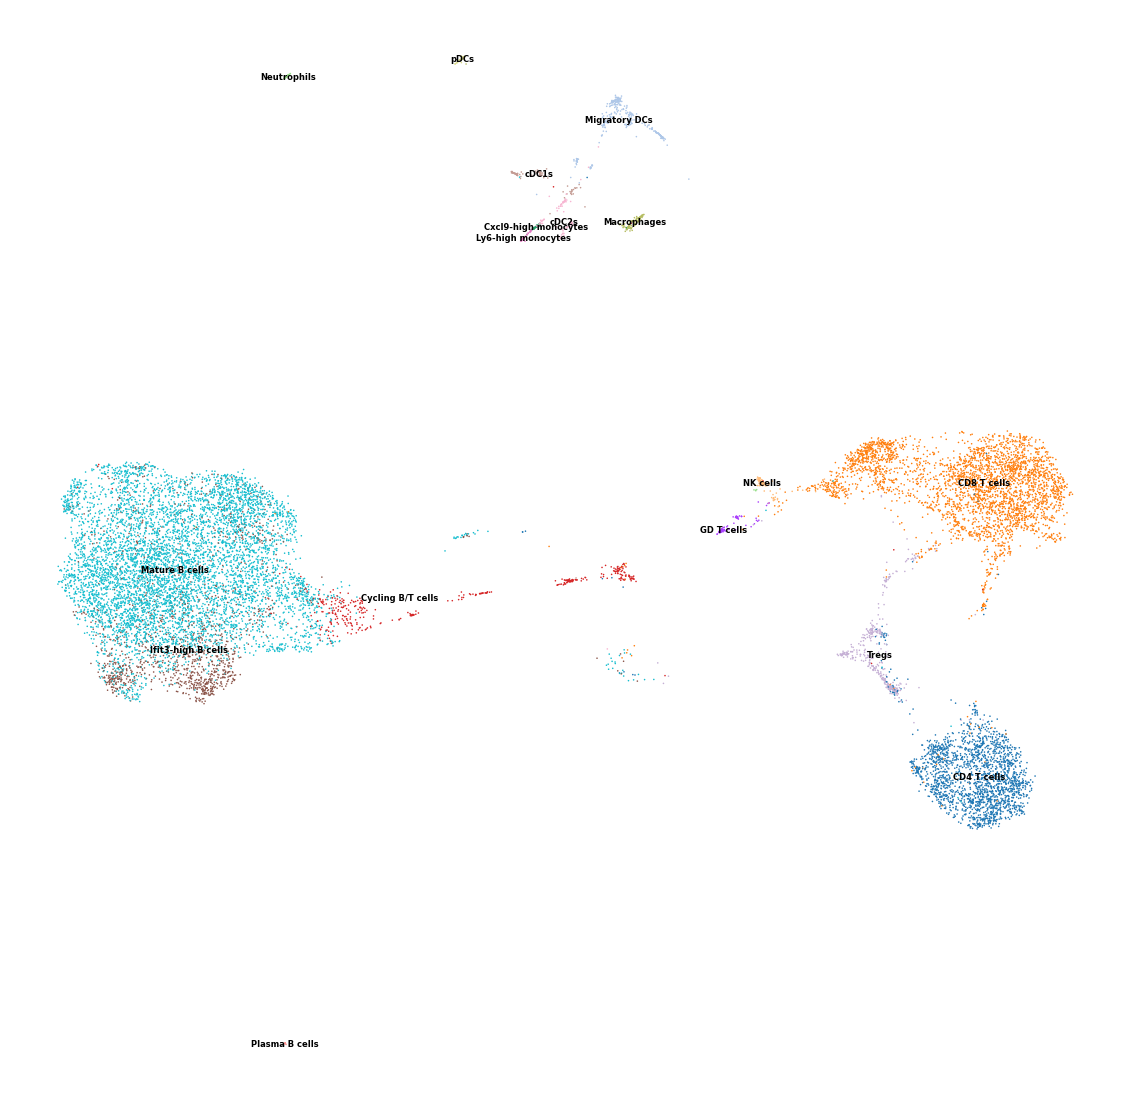

In [17]:
fig, ax = plt.subplots(figsize=(20, 20))
sc.pl.umap(
    nova_data, 
    color="cell_types",
    frameon=False,
    title="",
    legend_loc="on data",
    legend_fontsize="small",
    ax=ax, size=10
)
fig.savefig("figures/UMAP_nova.pdf")

In [ ]:
mapping = {"Mature B cells": "B cells", 
           "Ifit3-high B cells": "B cells",
           "Cycling B/T cells": "B cells",
            "Plasma B cells": "NA",
        "Neutrophils": "NA",
           "Ly6-high monocytes": "Monocytes",
           "Cxcl9-high monocytes": "Monocytes"}

res = []
for x in nova_data.obs["cell_types"]:
    local = x
    if x in mapping:
        local = mapping[x]
    res.append(local)
    
# res = [mapping[x] if x in mapping else x for x in nova_data.obs["cell_types"]]

nova_data.obs["broad_cell_types"] = res
nova_data = nova_data[nova_data.obs["broad_cell_types"] != "NA"].copy()

In [15]:
sc.write("nova_final_data.h5ad", nova_data)